In [1]:
import numpy as  np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

In [2]:
x0 = 0
x1 = 1
t0 = 0
t1 = 1
tn = 1000 #num_t
xm = 1000 #num_x
c = 1

In [3]:
T = np.linspace(t0, t1, tn+1)
X = np.linspace(x0, x1, xm+1)
[x,t] = np.meshgrid(T,X)
dx = (x1 - x0)/xm
dt = (t1 - t0)/tn

In [28]:
x.shape,len(T),len(X)

((1001, 1001), 1001, 1001)

In [4]:
dt,dx/c

(0.001, 0.001)

In [17]:
np.arange(x0,x1,0.001)[0],np.arange(x0,x1,0.001)[-1]

(0.0, 0.999)

In [22]:
def T_fn(x, t):
    u = 0.8
    D = 0.4
    return np.exp(-(x - 5.5 - u * t) ** 2 / D) \
           + np.heaviside(x - 1 - u * t, 0.5) * np.heaviside(-(x - 2 - u * t), 0.5) \
           + np.minimum(np.maximum(x - 3 - u * t, 0), np.maximum(-(x - 4 - u * t), 0)) * 2


In [23]:
U_init = T_fn(X,0)
U_left = T_fn(0,T)
U_right= T_fn(1,T)

In [5]:
U = np.zeros(x.shape)
U_init = np.sin(2*np.pi*X)  #初始条件 U(x,0) = f(x)
#U_init = np.zeros(X.shape)
#U_init[0:int(m/5)] = 1
U_left = -np.sin(2*np.pi*c*T) #左边界 U(0,t) = f(t) 对于有限边界，左边界必须给定边界值，右边界不能给定边界值
U_right= np.sin(2*np.pi*(X[-1]-c*T))# 右边界 U(x=1,t) 给定右边界属于过给定问题，但是在空间差分格式中保证给到合适的边界值
#U_left  = np.zeros(T.shape)
#U_right = np.ones(T.shape)
#U_init[20:40] = 1

#U_ana = np.sin(2*np.pi*(x-c*t)) # 对流方程其解为 u(x,t) = f(x-ct)


In [24]:
#up-wind
U1 = np.zeros(x.shape)
U1[:,0] = U_init #t=0 u(x,t=0) = f(x)
U1[0,:] = U_left #x=0 u(x=0,t) = f(t)
for n in range(len(T)-1):
    U1[1:-1, n+1] = U1[1:-1, n] - c*dt/dx*(U1[1:-1, n] - U1[0:-2,n]) #u(i,n+1) = u(i,n) - c*(dt/dx)(u(i,n)-u(i-1,n)), (c>0)
    U1[-1, n+1] = U1[-1, n] - c*dt/dx*(U1[-1, n] - U1[-2,n]) #边界处

'''
#leapfrog 有问题，实际上直接知道了下一个时刻的解
U2 = np.zeros(np.shape(x))
U2[:,0] = U_init
U2[0,:] = U_left
U2[:,1] = U_ana[:,1] # 不应该直接使用解析解给定值
U2[-1,:] = U_ana[-1,:]
for n in range(len(T)-2):
    U2[1:-2, n+2] = U2[1:-2, n] - dt/dx*(U2[2:-1, n+1] - U2[0:-3,n+1])
    U2[-2, n+2] = U2[-2, n] - dt/dx*(U2[-1, n+1] - U2[-3,n+1])
'''

#time forward, space centering
U3 = np.zeros(np.shape(x))
U3[:,0] = U_init
U3[0,:] = U_left
U3[-1,:] = U_right  #这一步默认已知边界处所有时刻的值,即给定了右边界，过给定问题
for n in range(len(T)-1):
    # u(i,n+1)=u(i,n)-(0.5*c*dt/dx)*(u(i+1,n)-u(i-1,n)
    U3[1:-2, n+1] = U3[1:-2, n] - 0.5*c*dt/dx*(U3[2:-1, n] - U3[0:-3,n])     
    U3[-2, n+1] = U3[-2, n] - 0.5*c*dt/dx*(U3[-1, n] - U3[-3,n])
    
#Lax-Friedrichs
U4 = np.zeros(np.shape(x))
U4[:,0] = U_init
U4[0,:] = U_left
U4[-1,:] = U_right
for n in range(len(T)-1):
    U4[1:-2, n+1] = 0.5*(U4[2:-1, n] + U4[0:-3,n]) - 0.5*c*dt/dx*(U4[2:-1, n] - U4[0:-3,n])
    U4[-2, n+1] = 0.5*(U4[-1, n] + U4[-3,n]) - 0.5*c*dt/dx*(U4[-1, n] - U4[-3,n])

#
U5 = np.zeros(np.shape(x))
U5[:,0] = U_init
U5[0,:] = U_left
U5[-1,:] = U_right
for n in range(len(T)-1):
    U5[1:-2, n+1] = U5[1:-2, n] - 0.5*dt/dx*(U5[2:-1, n] - U5[0:-3,n]) + 0.5*dt**2/dx**2*(U5[2:-1, n] -2*U5[1:-2, n] + U5[0:-3,n])
    U5[-2, n+1] = U5[-2, n] - 0.5*dt/dx*(U5[-1, n] - U5[-3,n]) + 0.5*dt**2/dx**2*(U5[-1, n] -2*U5[-2, n] + U5[-3,n])


In [25]:
def Thomas(La, Mb, Uc, b):
    """
    Arguments:
        La -- [lower item for tri-diagonal matrix]
        Mb -- [mian item for tri-diagonal matrix]
        Uc -- [upper item for tri-diagonal matrix]
        b -- [AX = b, where A is the tri-diagonal matrix]
    """
    n = len(Mb)
    Uc[0] = Uc[0] / Mb[0]
    for i in range(1, n-1):
        Uc[i] = Uc[i] / (Mb[i] - La[i - 1] * Uc[i - 1])
    b[0] = b[0] / Mb[0]
    for i in range(1, n):
        b[i] = (b[i] - La[i-1]*b[i-1]) / (Mb[i] - La[i-1] * Uc[i-1])
    ls = list(range(n-1))[::-1]
    for i in ls:
        b[i] = b[i] - Uc[i]*b[i+1]
        
    return np.array(b)

In [26]:
#fully implicit（全隐）
U6 = np.zeros(np.shape(x))
U6[:,0] = U_init
U6[0,:] = U_left
U6[-1,:]= U_right

for n in range(len(T)-1):
    a = -0.5*c*dt/dx*np.ones((len(X)-3))#给出矩阵三条对角线的值
    b = np.ones((len(X)-2))
    C = 0.5*c*dt/dx *np.ones((len(X)-3))
    k = []
    for i in range(len(X)-2):
        k.append(U6[i+1,n])
    
    k[0]  += 0.5*c*dt/dx*U6[0,n+1]
    k[-1] -= 0.5*c*dt/dx*U6[-1,n+1]#计算Ax=b中的b
    
    U6[1:-1,n+1] = Thomas(a,b,C,k)#求x


#Crack-Nicholson
U7 = np.zeros(np.shape(x))
U7[: ,0]= U_init
U7[0 ,:]= U_left
U7[-1,:]= U_right

for n in range(len(T)-1):
    a = -0.25*c*dt/dx*np.ones((len(X)-3))
    b = np.ones((len(X)-2))
    C = 0.25*c*dt/dx*np.ones((len(X)-3))
    k = []
    for i in range(len(X)-2):
        k.append(U7[i+1,n]-0.25*c*dt/dx*(U7[i+2,n]- U7[i,n]))
    
    k[0]  += 0.25*c*dt/dx*U7[ 0,n+1]
    k[-1] -= 0.25*c*dt/dx*U7[-1,n+1]
    U7[1:-1,n+1] = Thomas(a,b,C,k)

    
#跳点（本质是显格式）
U8 = np.zeros(np.shape(x))
U8[:,0] = U_init
U8[0,:] = U_left
U8[-1,:] = U_right

for n in range(len(T)-1):
    for i in range(len(X)-2):
        if (n+i+1)%2 == 0:
            U8[i+1,n+1] = U8[i+1,n] - 0.5*c*dt/dx*(U8[i+2,n]-U8[i,n])
    for i in range(len(X)-2):
        if (i+n+1)%2 != 0:
            U8[i+1,n+1] = U8[i+1,n] - 0.5*c*dt/dx*(U8[i+2,n+1]-U8[i,n+1])

            
   

MovieWriter ffmpeg unavailable; using Pillow instead.


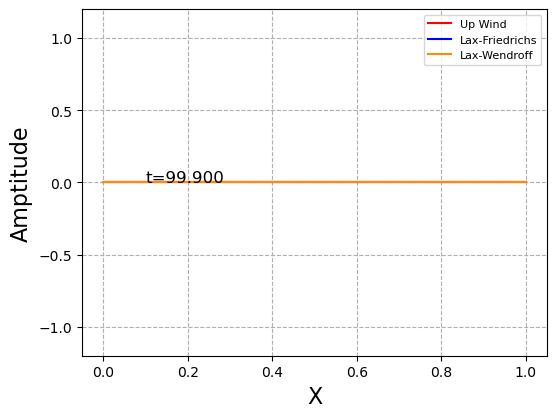

In [27]:
from matplotlib import animation
import matplotlib as mpl

fig = plt.figure(figsize = (6,4.5),dpi=100)
plt.grid(ls='--')
ani1, = plt.plot(X, U1[:,0],color='red', label="Up Wind")
#ani2, = plt.plot(X, U2[:,0],color='green', label="leapfrog")
#ani3, = plt.plot(X, U3[:,0], color='m',label="time forward, space centering")
ani4, = plt.plot(X, U4[:,0], color='blue',label="Lax-Friedrichs")
ani5, = plt.plot(X, U5[:,0], color='darkorange',label="Lax-Wendroff")
                     
plt.xlabel("X", fontsize = 16)
plt.ylabel("Amptitude", fontsize = 16)
plt.legend(loc='best',fontsize=8)

text_ani = plt.text(0.1, 0, '',fontsize=12)
plt.ylim(-1.2,1.2)
def update(n):
    ani1.set_data(X, U1[:,n])
    #ani2.set_data(X, U2[:,n])
    #ani3.set_data(X, U3[:,n])
    ani4.set_data(X, U4[:,n])
    ani5.set_data(X, U5[:,n])
    t = n/10.
    text_ani.set_text('t=%.3f'%t)
    return [ani1,ani4,ani5,text_ani]

ani = animation.FuncAnimation(fig=fig, func = update, frames = np.arange(0,n+1), interval = 20)
ani.save('ini_sin.gif')
plt.show()




MovieWriter ffmpeg unavailable; using Pillow instead.


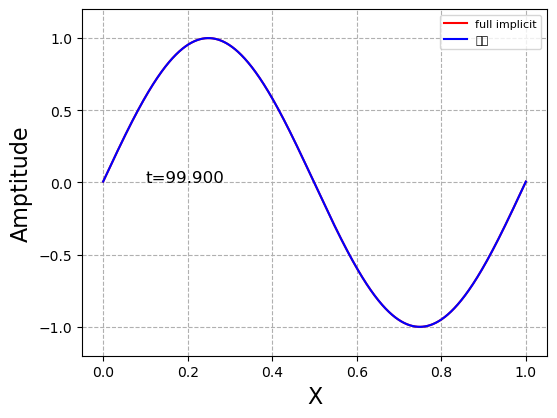

In [12]:
from matplotlib import animation
import matplotlib as mpl

fig = plt.figure(figsize = (6,4.5),dpi=100)
plt.grid(ls='--')
ani6, = plt.plot(X, U6[:,0],color='red', label="full implicit")
#ani7, = plt.plot(X, U7[:,0], color='m',label="Crack-Nicholson")
ani8, = plt.plot(X, U8[:,0], color='blue',label="跳点")
                     
plt.xlabel("X", fontsize = 16)
plt.ylabel("Amptitude", fontsize = 16)
plt.legend(loc='best',fontsize=8)

text_ani = plt.text(0.1, 0, '',fontsize=12)
plt.ylim(-1.2,1.2)
def update(n):
    ani6.set_data(X, U1[:,n])
    #ani7.set_data(X, U3[:,n])
    ani8.set_data(X, U4[:,n])
    t = n/10.
    text_ani.set_text('t=%.3f'%t)
    return [ani6,ani8,text_ani]

ani = animation.FuncAnimation(fig=fig, func = update, frames = np.arange(0,n+1), interval = 20)
ani.save('ini_sin2.gif')
plt.show()


